In [1]:
# Class
from maiga import mg

# 리스트 평평하게
import itertools

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

데이터 가져오기

In [2]:
voice_df = mg.get_bigquery_df("""
    SELECT cd105.value as voice_result, count(*) as count
    FROM `maimovie.205667858.ga_sessions_20*`
    LEFT JOIN UNNEST(hits) as hits
    LEFT JOIN UNNEST(hits.CustomDimensions) as cd105 on cd105.index=105
    WHERE regexp_contains(device.operatingSystem, 'Android|iOS')
    and _table_suffix between '200313' and '200610'
    GROUP BY voice_result
    ORDER BY count ASC;""")

- - - - - 완료 (10초 / 0.17) - - - - -


결측값 제거

In [3]:
voice_df = voice_df[voice_df['voice_result'].notnull()].reset_index(drop = True)

소문자로

In [4]:
voice_df['voice_result'] = voice_df['voice_result'].str.lower()

기타

In [5]:
# Hong Kong → Hong-Kong
voice_df['voice_result'] = voice_df['voice_result'].str.replace('hong kong', 'hongkong')

In [6]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /Users/mizy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/mizy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
def remove_stopwords(words):
    words = [w for w in words if w not in stopwords.words('english')]
    return words

In [8]:
test = voice_df.copy()

토큰화 & Stopwords 제거

In [9]:
# Tokenization
test['voice_clean'] = test['voice_result'].apply(lambda x: text_to_word_sequence(x))

# Remove stopwords
test['voice_clean'] = test['voice_clean'].apply(lambda x: remove_stopwords(x))

복수형을 단수로 만들기

In [10]:
from nltk.stem import WordNetLemmatizer 
  
lemm = WordNetLemmatizer() 

def lemmatizer(word_list):
    list_len = len(word_list)
    word_lemm = []
    for ll in range(list_len):
        word_lemm.append(lemm.lemmatize(word_list[ll]))
    return word_lemm

In [11]:
test['voice_clean'] = test['voice_clean'].apply(lambda x: lemmatizer(x))

### 워드클라우드

1. 단어별 빈도에 따라

In [12]:
from collections import Counter

text = list(itertools.chain.from_iterable(test['voice_clean'] * test['count']))
text = dict(Counter(text))

In [13]:
from wordcloud import WordCloud
wordcloud = WordCloud(width = 20000, 
                      height = 20000, 
                      background_color='white').generate_from_frequencies(text)


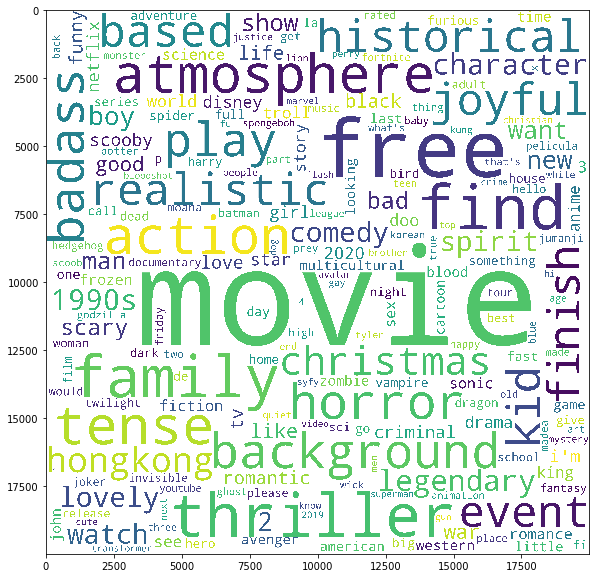

In [14]:
plt.figure(figsize = (15, 10))
plt.imshow(wordcloud)